In [322]:
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import folium 
import matplotlib.pyplot as plt
import platform
from datetime import datetime
import warnings
import os
import glob
warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = 'AppleGothic'  # 사용할 한글 폰트 설정

### 1. 데이터 불러오기

In [323]:
uselog = pd.read_csv('./Data-in/use_log.csv')
customer = pd.read_csv('./Data-in/customer_master.csv')
class_master= pd.read_csv('./Data-in/class_master.csv')
campaign_master = pd.read_csv('./Data-in/campaign_master.csv')

In [324]:
print(len(uselog))
print(len(uselog['customer_id'].unique()))
uselog.head() # 센터 이용 이력 데이터

197428
4192


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [325]:
# 2019년 3월 말 시점의 회원 데이터
# is_deleted: 탈퇴한 유저를 빨리 찾기 위한 필드
# name은 마스킹 되어 있어서 , name으로 개인을 특정짓기 히믐
# 탈퇴한 회원도 포함
print(len(customer))
print(len(customer['customer_id'].unique()))
print(customer['end_date'].value_counts())
customer.loc[customer['is_deleted']==0] # 탈퇴한 유저 제외

4192
4192
end_date
2019-02-28 00:00:00    149
2019-01-31 00:00:00    129
2018-05-31 00:00:00    125
2018-04-30 00:00:00    121
2018-08-31 00:00:00    113
2018-12-31 00:00:00    111
2019-03-31 00:00:00    111
2018-06-30 00:00:00    106
2018-09-30 00:00:00    104
2018-07-31 00:00:00    102
2018-10-31 00:00:00     90
2018-11-30 00:00:00     89
Name: count, dtype: int64


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0
...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,NaN,CA1,0
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,NaN,CA1,0
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0


In [326]:
class_master.head() # 회원 구분 데이터(종일, 주간 야간)

,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [327]:
campaign_master.head() # 행사 구분 데이터(입회비 유무 등)

,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


### 2.고객 데이터 가공

In [328]:
# 기준 데이터 : 고객 데이터(customer), 이용 이력 데이터(uselog)
customer_join = pd.merge(customer, class_master, on='class',how = 'left')
customer_join = pd.merge(customer_join, campaign_master, on = 'campaign_id', how = 'left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [329]:
customer_join.isna().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

### 3.고객 데이터 집계

In [330]:
# 집계 항목
    # 어떤 회원과 어떤 캠페인이 많은가
    # 언제 입회/탈퇴가 많은가
    # 남여 비율은 어떠한가
    # 탈퇴할 때까지의 기간은 어느 정도인가

* 캠페인 구분과 성별, 이미 탈퇴 했느지 안했는지(is_delete)

In [331]:
# class_name 에 따른 count
# 종일반이 거의 절반을 차지 : 종일 > 야간 > 주간
customer_join.groupby('class_name').count()['customer_id'].reset_index()

,class_name,customer_id
0,0_종일,2045
1,1_주간,1019
2,2_야간,1128


In [332]:
# campaign_id 에 따른 count
# 일반가격으로 입회비를 내시는 분이 제일 많다 : 일반 > 반액할인 > 무료
customer_join.groupby('campaign_name').count()['customer_id'].reset_index()


,campaign_name,customer_id
0,0_입회비반액할인,650
1,1_입회비무료,492
2,2_일반,3050


In [333]:
# 성별에 따른 고객수 count

customer_join.groupby(['gender']).count()['customer_id'].reset_index()

,gender,customer_id
0,F,1983
1,M,2209


In [334]:
# 가입 탈퇴 회원 count
# 결과 : 2019년 3월 기준, 가입된 회원 2842명, 탈퇴 회원 1350명
customer_join.groupby('is_deleted').count()['customer_id'].reset_index()

,is_deleted,customer_id
0,0,2842
1,1,1350


In [335]:
# 2018/4/1 ~ 2019/3/31 가입 인원을 집계
cu = customer_join.loc[customer_join['start_date']>'2018-04-01'].groupby('start_date').count()['customer_id'].reset_index().copy()
cu

,start_date,customer_id
0,2018-04-01 00:00:00,15
1,2018-04-02 00:00:00,6
2,2018-04-03 00:00:00,9
3,2018-04-04 00:00:00,10
4,2018-04-05 00:00:00,11
...,...,...
175,2019-03-11 00:00:00,3
176,2019-03-12 00:00:00,8
177,2019-03-13 00:00:00,4
178,2019-03-14 00:00:00,4


In [336]:
sum(cu['customer_id'])

1376

In [337]:
len(customer_join['customer_id'].unique())

4192

### 4.최근 고객데이터 집계

In [338]:
# 가장 최근 월의 고객 추출
    # 방법 1: 2019/3/31에 탈퇴한 고객과 재적중인 고객을 추출
    # 방법 2: is_deleted 열로 추출, 2019/3월에 탈퇴한 고객은 카운트

In [339]:
# 방법 1
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])
customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_join['year_month'] = customer_join['start_date'].dt.strftime('%Y%m')
customer_newer = customer_join.loc[(customer_join['end_date']>=pd.to_datetime('20190331'))|(customer_join['end_date'].isna())]
print(len(customer_newer))

2953


In [340]:
customer_newer.groupby('class_name').count()['customer_id']

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [341]:
# 전체 집계(탈퇴회원 포함) : 일반회원의 비율은 72%, 입적회원집계: 81%
# 결과 : 입회 캠페인은 회원비율 변화에 영향을 미침
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [342]:
# 성별에 의해 탈퇴한 비중은 높지 않음
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

In [343]:
customer_newer

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,year_month
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,201505
...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반,201903
4188,HD246549,XXXXX,C01,F,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반,201903
4189,GD037007,XXXXX,C03,M,2019-03-14,NaT,CA1,0,2_야간,6000,2_일반,201903
4190,OA953150,XXXXX,C01,M,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반,201903


### 5.이용이력 데이터 집계

In [344]:
# 시간적인 요소 분석 가능
    # 한 달 이용 횟수의 변화
    # 회원이 스포츠 센터를 정기적/비정기적으로 이용하는가?

* 월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값, 정기적 이용 여부의 플래그 작성 후
고객데이터에 추가

In [345]:
# 고객마다 월 이용 횟수를 집계

In [346]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월','customer_id'])['customer_id'].count().reset_index(name = 'count')
uselog_months

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [347]:
uselog_customer = uselog_months.groupby('customer_id')['count'].agg(['mean','median','max','min'])
#uselog_customer = uselog_customer.reset_index(drop = False)
uselog_customer.head()

,mean,median,max,min
customer_id,,,,
AS002855,4.500000,5.0,7,2
AS008805,4.000000,4.0,8,1
AS009013,2.000000,2.0,2,2
AS009373,5.083333,5.0,7,3
AS015233,7.545455,7.0,11,4


### 6. 이용이력 데이터로부터 정기이용 여부 플래그를 작성

In [348]:
# 정기적 : 매주 같은 요일에 왔는지 아닌지로 판단
# 월별 정기적 이용 여부 : 고객마다 월/요일별로 집계
# 최댓값이 4이상인 요일이 하나라도 있는 회원은 플래그를 1로 처리

In [349]:
# 고객마다 월/요일별로 집계
# 결과 AS002855는 201804에 5(토) 4번, 201805에 5(토) 4번, 201806에 5(토) 5번))
# AS002855은 체육관을 토요일에 항상 오는 날로 생각함

# 요일을 숫자로 변환 : 0~6까지 숫자(월~일요일)
uselog['weekday'] = uselog['usedate'].dt.weekday

# 고객, 연월, 요일별로 log_id를 count
uselog_weekday = uselog.groupby(['customer_id','연월','weekday'],
as_index=False).count()[['customer_id','연월','weekday','log_id']]
uselog_weekday.rename(columns = {'log_id':'count'},inplace=True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [350]:
# 고객별로 최댓값이 4이상인 경우에 플래그를 1로 지정
uselog_max = uselog_weekday.groupby('customer_id')['count'].max().reset_index(name = 'count').copy()
uselog_max['flag'] = 0
#교수님
uselog_max['flag'] = uselog_max['flag'].where(uselog_max['count']<4,1)



# #강희
# for i in range(len(uselog_max)):
#     if uselog_max['count'][i] >=4:
#         uselog_max['flag'][i] =1
#     else:
#         uselog_max['flag'][i] = 0

In [351]:
uselog_max

,customer_id,count,flag
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1
...,...,...,...
4187,TS995853,5,1
4188,TS998593,5,1
4189,TS999079,5,1
4190,TS999231,5,1


### 7. 고객 데이터와 이용 이력데이터를 결합

In [352]:
# customer_join + uselog_customer
# customer_join + uselog_weekday
customer_join = pd.merge(customer_join, uselog_customer, how = 'left',on = 'customer_id')
customer_join = pd.merge(customer_join, uselog_max[['customer_id','flag']], how = 'left',on = 'customer_id')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,year_month,mean,median,max,min,flag
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,201505,3.916667,4.0,6,1,1


### 8. 회원기간 계산

In [353]:
# start_date와 end_date의 차이

from dateutil.relativedelta import relativedelta

customer_join['calc_date'] = customer_join['end_date']
customer_join['calc_date'] = customer_join['calc_date'].fillna(pd.to_datetime('20190430'))

customer_join['membership_period'] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join['calc_date'].iloc[i],
                          customer_join['start_date'].iloc[i])
    customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,year_month,mean,median,max,min,flag,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,201505,3.916667,4.0,6,1,1,2019-04-30,47


### 9. 고객행동의 각종통계량을 파악

In [354]:
customer_join[['mean','median','max','min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [355]:
customer_join.groupby('flag').count()['customer_id']

flag
0     779
1    3413
Name: customer_id, dtype: int64

<Axes: xlabel='membership_period', ylabel='Count'>

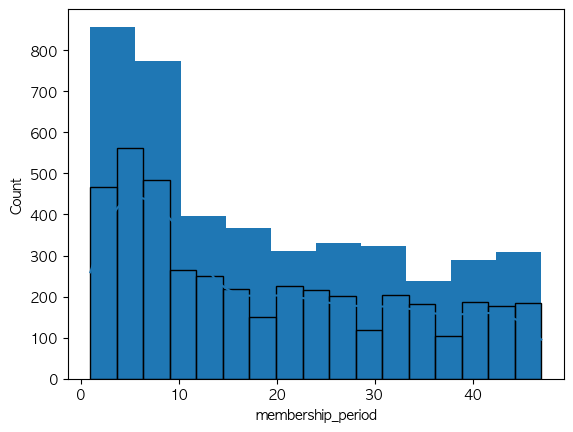

In [362]:
# 회원 기간의 분포
# 결론 : 회원기간이 10개월 이내인 고객이 많음, 고객의 수는 거의 일정
# 짧은 기간에 고객이 빠져나가는 업계
plt.hist(customer_join['membership_period'])
sns.histplot(data = customer_join, x = 'membership_period', kde = True)

### 10.탈퇴회원과 지속회원의 차이를 파악

In [366]:
# 탈퇴 회원 : 1350명, 지속 회원 : 2842명
customer_stay = customer_join.loc[customer_join['is_deleted']==1]
customer_stay.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,flag,calc_date,membership_period
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,2018-10-17 16:23:28,8.026667
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2018-04-30 00:00:00,1.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,2018-06-30 00:00:00,4.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,2018-10-31 00:00:00,7.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,2019-01-31 00:00:00,11.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,2019-03-31 00:00:00,23.000000
std,NaN,NaN,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,NaN,5.033692


In [367]:
# 결과
    # 결과 탈퇴 회원의 매월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값은 지속 회원보다 작다
    # 평균값과 중앙값은 1.5배 정도 차이가 남
    # 매월 최대 이용 횟수의 평균값은 지속 회원이 높음, 그러나 탈퇴 회원도 6.4정도 됨
    # flag 의 평균값은 차이가 크게 남. 지속 회원은 0.98로 많은 회원이 정기적으로 옴
    # flag의 탈퇴 회원은 0.45로 거의 절반은 랜덤하게 사용













In [369]:
customer_join.to_csv(r'./Data-out/customer_join.csv', index = False)